In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

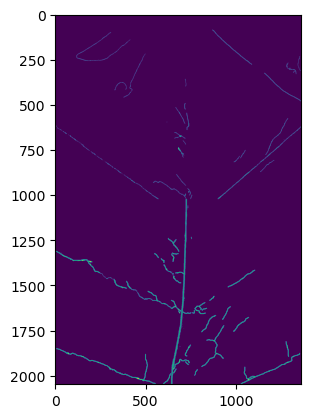

In [4]:
im = Image.open('./imageDamage/FineDamageReducedPNG/01_RCB0018_F03_DSC_0120000.png')
image = np.array(im)
plt.subplot(1, 1, 1)

# Display the image in the current subplot
plt.imshow(image)